In [2]:
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

import glob

import os

import pandas as pd

import matplotlib.pyplot as plt
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import numpy as np

from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

#!pip install --upgrade linear-tree
from lineartree import *

#import warnings
#warnings.filterwarnings("ignore")

my_random_state = 2022

In [5]:
path = "./beforeTrainning.csv"
m = pd.read_csv(path, sep = ",", usecols = ['10/17res', '10/17raw', '16/17res', '16/17raw', '17ma1raw', '17ma3raw',
       '17ma5raw', '17ma20raw', '17ma1-3raw', '17ma1-5raw', '17ma1-20raw',
       '17ma1res', '17ma3res', '17ma5res', '17ma20res', '17ma1-3res',
       '17ma1-5res', '17ma1-20res', 'market_value', '10/17vol', '16/17vol',
       'turnover_ma1', 'turnover_ma3', 'turnover_ma5', 'turnover_ma20',
       'estVol', 'cleanMid17', 'cleanMid16', 'cleanMid10', 'vol17', 'y'])
path = "./merged_with_dates.csv"
mwd = pd.read_csv(path, sep = ",")

In [6]:
train = m.loc[list(mwd[mwd["Date"] < 20170101].index)]
test = m.loc[list(mwd[mwd["Date"] >= 20170101].index)]

X_train = train.iloc[: , :-1]
y_train = train["y"]
X_test = test.iloc[: , :-1]
y_test = test["y"]

# scale the features in train set
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)

# do the same scaling to test set
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

In [5]:
def weighted_r2_scorer(model, X, y):

    r2_weight = 1 / np.array(X["estVol"])
    r2_weight = r2_weight / np.sum(r2_weight)
    
    y_pred = model.predict(X)
        
    return r2_score(y, y_pred, sample_weight = r2_weight)

## Linear Forest

In [6]:
# fit a linear forest regressor
regr = LinearForestRegressor(base_estimator = LinearRegression())
regr.fit(X_train_scaled, y_train)

AttributeError: 'LinearForestRegressor' object has no attribute 'plot_model'

In [9]:
y_pred = regr.predict(X_test_scaled)
r2_weight = 1 / X_test["estVol"]
print("Prediction score: ", r2_score(y_test, y_pred, sample_weight = r2_weight))

Prediction score:  -0.014045787194509218


In [11]:
y_pred = regr.predict(X_test_scaled)
r2_weight = 1 / X_test_scaled["estVol"]
print("Prediction score: ", r2_score(y_test, y_pred, sample_weight = r2_weight))

Prediction score:  1.2187360028813665


## Linear Boosting

In [28]:
## fit a linear boost regressor
lb = LinearBoostRegressor(base_estimator=LinearRegression(), loss='linear', n_estimators=30)
lb.fit(X_train, y_train)

LinearBoostRegressor(base_estimator=LinearRegression(), n_estimators=30)

In [29]:
y_pred_lb = lb.predict(X_test)
r2_weight = 1 / X_test["estVol"]
r2_weight = r2_weight / sum(r2_weight)
print("Prediction score: ", r2_score(y_test, y_pred_lb, sample_weight = r2_weight))

Prediction score:  4.0920949621825464e-05


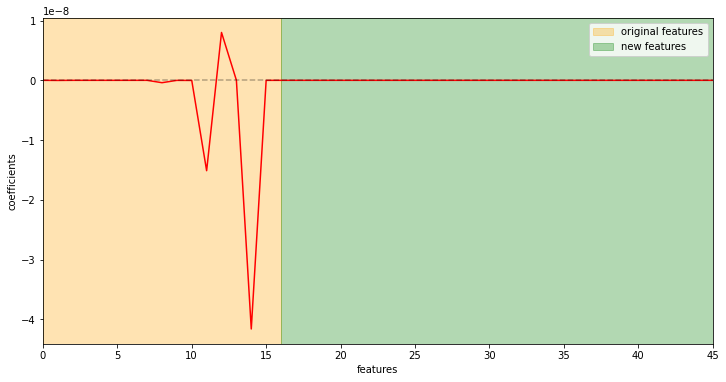

In [30]:
## show feature importances (coefficients)
plt.figure(figsize=(12,6))
plt.plot(lb.coef_, color='red')
plt.xlim(0, lb.coef_.shape[-1]-1)
plt.ylabel('coefficients'); plt.xlabel('features')
plt.axhline(0, c='black', linestyle='--', alpha=0.3)
plt.axvspan(0, X_train.shape[-1], alpha=0.3, color='orange', label='original features')
plt.axvspan(X_train.shape[-1], lb.coef_.shape[-1]-1, alpha=0.3, color='green', label='new features')
plt.legend()